<a href="https://colab.research.google.com/github/dvv3000/semantic-segmentation-using-Unet/blob/main/l%E1%BA%A7n_2__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Input là 60 ảnh đã gắn nhãn thủ công cộng với 219 ảnh được tạo từ model sau lần 1.

In [2]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Concatenate, Input, UpSampling2D, Lambda
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
INPUT_WIDTH = 512
INPUT_HEIGHT = 512
INPUT_CHANNELS = 3

In [4]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c
  


def UNet():
    f = [32, 64, 128, 256, 512]
    inputs = Input((INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS))
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) 
    c2, p2 = down_block(p1, f[1]) 
    c3, p3 = down_block(p2, f[2]) 
    c4, p4 = down_block(p3, f[3]) 
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) 
    u2 = up_block(u1, c3, f[2]) 
    u3 = up_block(u2, c2, f[1]) 
    u4 = up_block(u3, c1, f[0]) 
    
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = Model(inputs, outputs)
    return model
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
TRAIN_PATH = '/content/drive/MyDrive/Sematic Segmentation/train'
TEST_PATH = '/content/drive/MyDrive/Sematic Segmentation/test/test1'

train_id = next(os.walk(TRAIN_PATH))[1]
test_id = next(os.walk(TEST_PATH))[1]

In [9]:
print(train_id)
print(test_id)

['8', '55', '60', '59', '56', '9', '6', '57', '7', '58', '5', '48', '53', '52', '49', '47', '46', '51', '54', '50', '45', '43', '37', '4', '39', '41', '40', '42', '44', '38', '33', '32', '35', '34', '3', '30', '36', '29', '31', '28', '25', '27', '23', '19', '20', '21', '2', '24', '26', '22', '16', '17', '18', '10', '12', '14', '13', '1', '11', '15', '70', '66', '71', '65', '67', '69', '64', '63', '62', '61', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '211', '212', '213', '214', '215', '216', '217', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', 

In [ ]:
#load file train

X_train = []
Y_train = []
print('Getting and resizing train images ... ')
for index, folder in enumerate(os.listdir(TRAIN_PATH)):
  path = os.path.join(TRAIN_PATH, folder) 
  img = image.load_img(path + '/images/' + folder + '.jpg', target_size=(INPUT_HEIGHT, INPUT_WIDTH))
  img = image.img_to_array(img)
  X_train.append(img) # Appending the images to the X_train array
  #Load mask
  for mask_file in os.listdir(path + '/masks/'):
    mask = image.load_img(path + '/masks/' + mask_file, target_size=(INPUT_HEIGHT, INPUT_WIDTH), color_mode='grayscale')
    mask = image.img_to_array(mask)
  Y_train.append(mask)
  # print(path + '/images/' + folder + '.jpg')



Getting and resizing train images ... 


In [ ]:
#Load file test
X_test = []
sizes_test = [] # To upsample during making predicting
print('Getting and resizing test images ... ')

for index, folder in enumerate(os.listdir(TEST_PATH)):
  path = os.path.join(TEST_PATH, folder)
  img = image.load_img(path + '/images/' + folder + '.jpg', target_size=(INPUT_HEIGHT, INPUT_WIDTH))
  img = image.img_to_array(img)
  sizes_test.append([img.shape[0], img.shape[1]])
  X_test.append(img)
  # print(path + '/images/' + folder + '.jpg')

Getting and resizing test images ... 


In [ ]:
X_train = np.asarray(X_train).astype('float32')
X_train = X_train / 255.
Y_train = np.asarray(Y_train).astype('float32')
Y_train = Y_train / 255.
X_test = np.asarray(X_test).astype('float32')
X_test = X_test / 255.

In [ ]:
print(X_test.shape)
print(X_train.shape)
print(Y_train.shape)

(21, 512, 512, 3)
(279, 512, 512, 3)
(279, 512, 512, 1)


In [ ]:
print("Training image")
plt.imshow(X_train[0])
plt.show()
print("Mask of the image")
plt.imshow(np.squeeze(Y_train[0]))
plt.show()

print("Test image", test_id[5])
plt.imshow(X_test[5])
plt.show()

In [ ]:
model = load_model('/content/drive/MyDrive/6.h5')

# Initialize our callbacks
# This will save the best weights only
checkpoint = ModelCheckpoint('/content/drive/MyDrive/7.h5',
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
# It will stop training if validation accuracy doesn't improve
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)


# Fit our model 
results = model.fit(X_train, Y_train, validation_split=0.2,
                    batch_size=4, epochs=30,
                    callbacks=[checkpoint, earlystop],
                    verbose=1)

Epoch 1/30
56/56 [==============================] - 20s 351ms/step - loss: 0.0103 - acc: 0.9861 - val_loss: 0.0066 - val_acc: 0.9842

Epoch 00001: val_loss improved from inf to 0.00658, saving model to /content/drive/MyDrive/7.h5
Epoch 2/30
56/56 [==============================] - 20s 354ms/step - loss: 0.0105 - acc: 0.9860 - val_loss: 0.0072 - val_acc: 0.9838

Epoch 00002: val_loss did not improve from 0.00658
Epoch 3/30
56/56 [==============================] - 19s 344ms/step - loss: 0.0103 - acc: 0.9861 - val_loss: 0.0070 - val_acc: 0.9844

Epoch 00003: val_loss did not improve from 0.00658
Epoch 4/30
56/56 [==============================] - 19s 341ms/step - loss: 0.0106 - acc: 0.9860 - val_loss: 0.0061 - val_acc: 0.9844

Epoch 00004: val_loss improved from 0.00658 to 0.00615, saving model to /content/drive/MyDrive/7.h5
Epoch 5/30
56/56 [==============================] - 19s 344ms/step - loss: 0.0102 - acc: 0.9861 - val_loss: 0.0072 - val_acc: 0.9839

Epoch 00005: val_loss did not im

In [ ]:
# model = load_model('/content/drive/MyDrive/model-segmentation.h5')
preds_test = model.predict(X_test, verbose=1)
# Thresholding
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 13s 13s/step


In [ ]:
# import random
# # Perform a sanity check on some random training samples
# ix = random.randint(0, len(preds_train_t))
# print("Training image")
# plt.imshow(X_train[ix])
# plt.show()
# print("Actual Mask")
# plt.imshow(np.squeeze(Y_train[ix]))
# plt.show()
# print("Predicted Thresholded Mask")
# plt.imshow(np.squeeze(preds_train_t[ix]))
# plt.show()

68


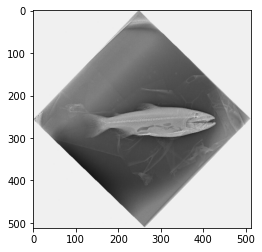

Predicted Thresholded Mask


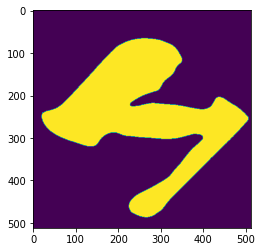

276


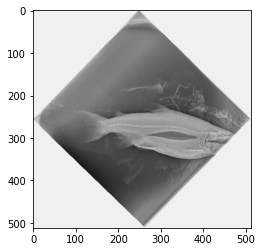

Predicted Thresholded Mask


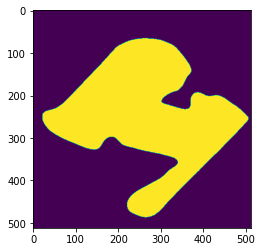

218


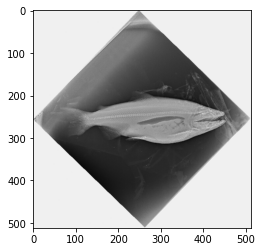

Predicted Thresholded Mask


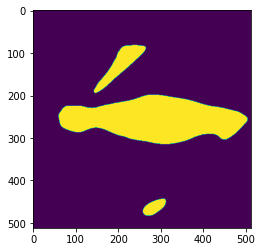

229


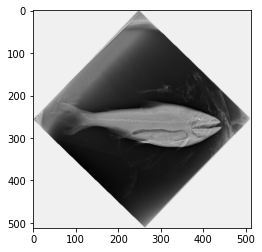

Predicted Thresholded Mask


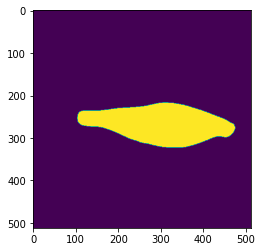

230


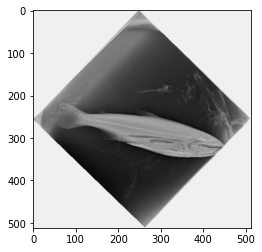

Predicted Thresholded Mask


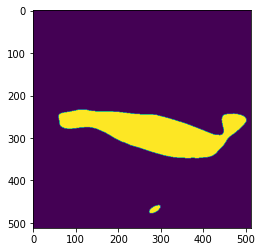

231


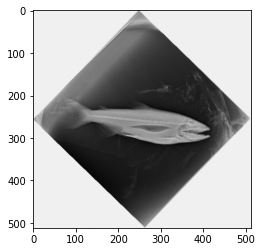

Predicted Thresholded Mask


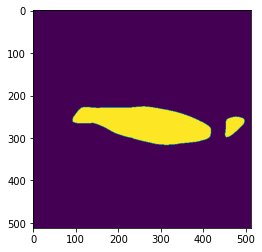

209


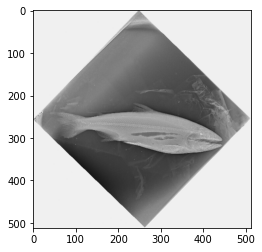

Predicted Thresholded Mask


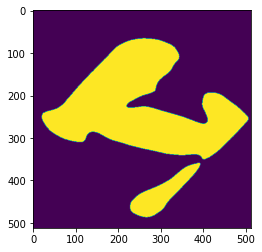

141


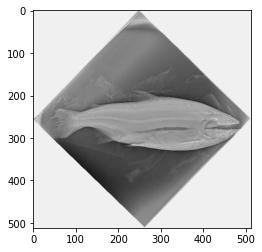

Predicted Thresholded Mask


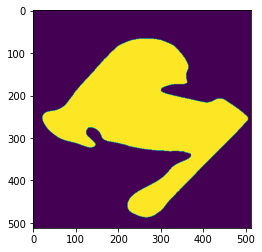

168


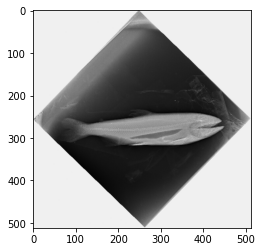

Predicted Thresholded Mask


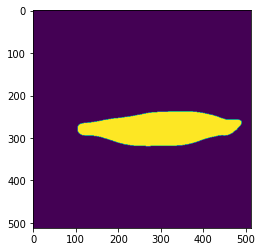

174


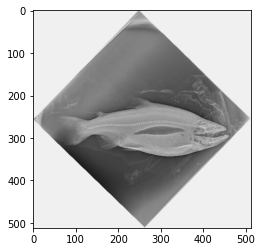

Predicted Thresholded Mask


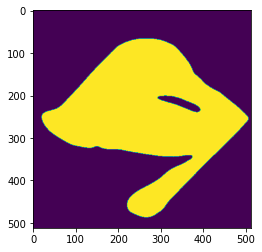

189


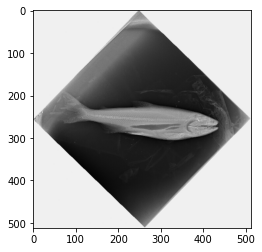

Predicted Thresholded Mask


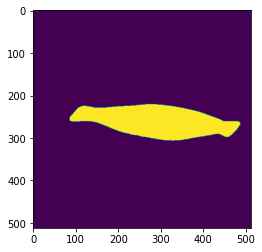

98


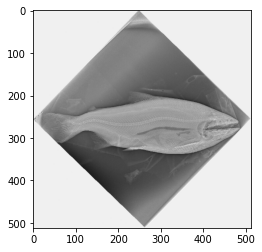

Predicted Thresholded Mask


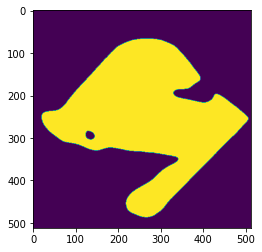

102


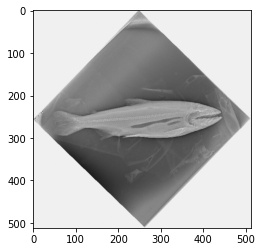

Predicted Thresholded Mask


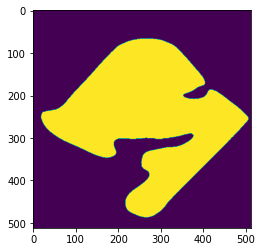

103


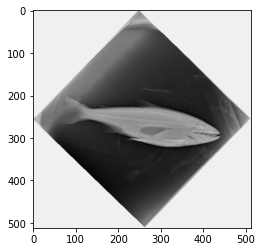

Predicted Thresholded Mask


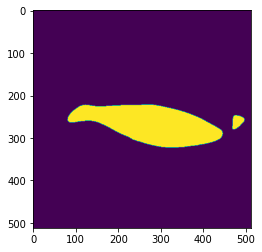

104


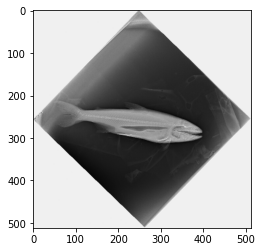

Predicted Thresholded Mask


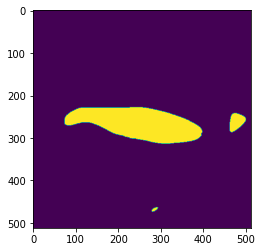

105


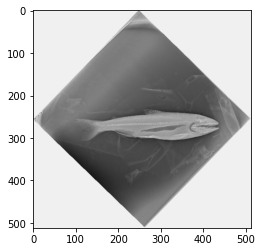

Predicted Thresholded Mask


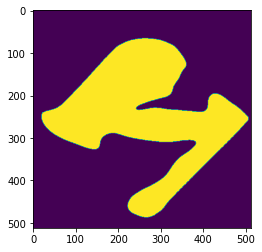

115


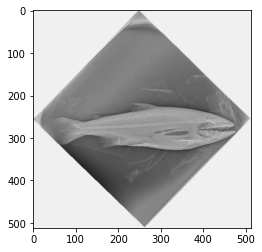

Predicted Thresholded Mask


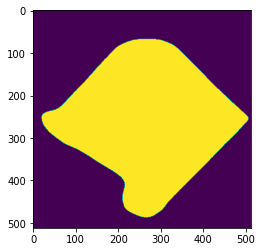

125


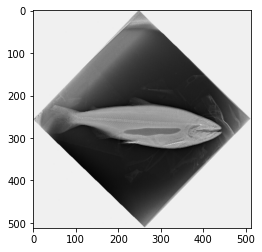

Predicted Thresholded Mask


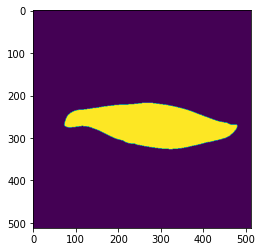

126


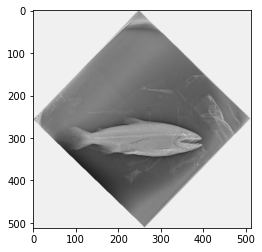

Predicted Thresholded Mask


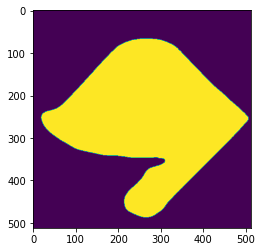

133


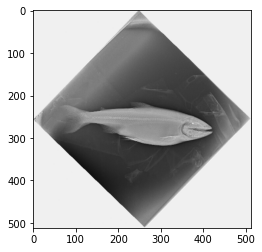

Predicted Thresholded Mask


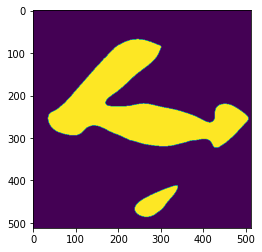

90


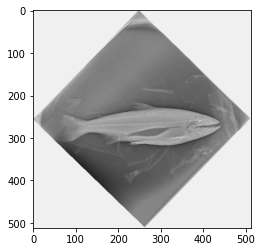

Predicted Thresholded Mask


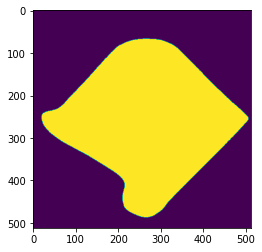

In [ ]:
for i in range(len(test_id)):
  print(test_id[i])
  plt.imshow(X_test[i])
  plt.show()
  print("Predicted Thresholded Mask")
  plt.imshow(np.squeeze(preds_test_t[i]))
  plt.show()

In [ ]:
import cv2

In [ ]:
# Create masks folder for each image

for folder in os.listdir(TEST_PATH):
  path = os.path.join(TEST_PATH, folder)
  mask_folder = os.path.join(path, 'masks')
  if os.path.exists(mask_folder) == False:
    os.mkdir(mask_folder)
    print(mask_folder)

In [ ]:
# Save masks

for i in range(len(test_id)):
  mask_name = TEST_PATH + '/' + test_id[i] + '/masks/' + test_id[i] + '.jpg'
  created_mask = image.array_to_img(preds_test_t[i])
  created_mask.save(mask_name)
  created_mask.show()